### signal pre-processing preparation

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time as t
import wave
import math
from numpy.fft import fft
import sys
import re
import librosa
import scipy.io as scio
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.python.ops.numpy_ops import np_config

#### find signal size

In [4]:
def findsize(path1, delay, index):
    wlen=1024
    inc=128

    f = wave.open(f'{path1}', "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    str_data = f.readframes(nframes)
    wave_data = np.frombuffer(str_data, dtype=np.short)
    wave_data = wave_data*1.0/(max(abs(wave_data)))
    time = np.arange(0, wlen) * (1.0 / framerate)
    fixed_signal = np.zeros(len(wave_data))
    if delay != 0:
        zeros=np.zeros(((wlen//6*delay),)) #在訊號前加0增加訓練集
        fixed_signal=np.concatenate((zeros,wave_data)) #填補後的信號記爲fixed_signal
    else:
        fixed_signal = wave_data
    #print(wave_data.dtype)
    signal_length=len(fixed_signal) #信號總長度
    if signal_length<=wlen: #若信號長度小於一個幀的長度，則幀數定義爲1
        nf=1
    else: #否則，計算幀的總長度
        nf=int(np.ceil((1.0*signal_length-wlen+inc)/inc))
    pad_length=int((nf-1)*inc+wlen) #所有幀加起來總的鋪平後的長度
    zeros=np.zeros((pad_length-signal_length,)) #不夠的長度使用0填補，類似於FFT中的擴充數組操作
    pad_signal=np.concatenate((fixed_signal,zeros)) #填補後的信號記爲pad_signal
    indices=np.tile(np.arange(0,wlen),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T  #相當於對所有幀的時間點進行抽取，得到nf*nw長度的矩陣
    indices=np.array(indices,dtype=np.int32) #將indices轉化爲矩陣
    #print(indices.shape)
    size = indices.shape[0]
    return size

#### 音檔疊合(由於不同音檔的幀率不同，此問題待解決)

In [3]:
def mix_wave_func(filepath1, filepath2):
    def read_wave(file):
        with wave.open(file, 'rb') as f:
            params = f.getparams()
            nchannels, sampwidth, framerate, nframes = params[:4]
            str_data = f.readframes(nframes)
            wave_data = np.frombuffer(str_data, dtype=np.int16)
            wave_data = wave_data.reshape(-1, nchannels)
        return wave_data, framerate

    # def write_wave(file, data, framerate):
    #     with wave.open(file, 'wb') as f:
    #         nchannels = data.shape[1] if len(data.shape) > 1 else 1
    #         sampwidth = 2  # 16-bit audio
    #         nframes = data.shape[0]
    #         comptype = "NONE"
    #         compname = "not compressed"
    #         f.setparams((nchannels, sampwidth, framerate, nframes, comptype, compname))
    #         f.writeframes(data.tobytes())

    def mix_waves(wave1, wave2):
        # Ensure both waves have the same number of channels and frames
        min_length = min(len(wave1), len(wave2))
        wave1 = wave1[:min_length]
        wave2 = wave2[:min_length]
        
        # Mix waves by adding the samples
        mixed_wave = wave1 + wave2

        # Normalize to prevent clipping
        max_val = np.max(np.abs(mixed_wave))
        if max_val > 32767:
            mixed_wave = mixed_wave * (32767.0 / max_val)
        
        return mixed_wave.astype(np.int16)

    # 讀取兩個聲音檔
    wave1, framerate1 = read_wave(filepath1)
    wave2, framerate2 = read_wave(filepath2)

    # 確保兩個聲音檔有相同的採樣率
    if framerate1 != framerate2:
        raise ValueError("Sample rates do not match")
        # target_rate = min(framerate1, framerate2)  # 選擇較低的採樣率
        # if framerate1 != target_rate:
        #     wave1 = librosa.resample(wave1, orig_sr=framerate1, target_sr=target_rate)
        # if framerate2 != target_rate:
        #     wave2 = librosa.resample(wave2, orig_sr=framerate2, target_sr=target_rate)
        # framerate1 = framerate2 = target_rate  # 更新採樣率

    # 混和音頻
    mixed_wave = mix_waves(wave1, wave2)

    return mixed_wave

#### audio preprocessing

In [10]:
def add_white_noise(signal, noise_factor = 0.005):
    noise = np.random.normal(loc = 0, scale = signal.std(), size = len(signal))
    wavelength = np.arange(0, len(noise))
    # plt.figure(figsize=(20,4))
    # plt.plot(wavelength, noise,c="g")
    # plt.xlabel('time (s)')
    # plt.ylabel('Amplitude(dB)')
    # plt.grid()
    # plt.xlim(0, 10000)
    # plt.show()
    # plt.savefig('white_noise.png')
    augmented_signal = signal + noise*noise_factor
    return augmented_signal

def audioProcessing(path1, delay, whitenoise, index = 0, maxindex = 167, addenvnoise = 0):

    #addsignalfilepath = 'car_crash_dataset/ESC50/馬路聲音.wav'
    wlen=1024
    inc=128

    f = wave.open(f'{path1}', "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]

    #add environment noise
    if addenvnoise == 0:
        str_data = f.readframes(nframes)
        wave_data = np.frombuffer(str_data, dtype=np.short)
    # elif addenvnoise == 1:
    #     wave_data = mix_wave_func(path1, addsignalfilepath)

    wave_data = wave_data*1.0/(max(abs(wave_data)))

    #add white noise
    if whitenoise == 1:
        # wavelength = np.arange(0, len(wave_data))
        # plt.figure(figsize=(20,4))
        # plt.plot(wavelength, wave_data,c="g")
        # plt.xlabel('time (s)')
        # plt.ylabel('Amplitude(dB)')
        # plt.grid()
        # plt.xlim(0, 10000)
        # plt.show()
        # plt.savefig('original.png')
        wave_data = add_white_noise(wave_data, 0.5)
        # plt.figure(figsize=(20,4))
        # plt.plot(wavelength, wave_data,c="g")
        # plt.xlabel('time (s)')
        # plt.ylabel('Amplitude(dB)')
        # plt.grid()
        # plt.xlim(0, 10000)
        # plt.show()
        # plt.savefig('fixed.png')
        # t.sleep(10)
    elif whitenoise == 3:
        wave_data = add_white_noise(wave_data, 0.3)
    elif whitenoise == 2:
        wave_data = add_white_noise(wave_data, 0.4)
    time = np.arange(0, wlen) * (1.0 / framerate)
    fixed_signal = np.zeros(len(wave_data))

    #data augmentation--加delay
    if delay != 0:
        zeros=np.zeros(((wlen//6*delay),))
        zeros=np.full(wlen//6*delay, 0.00001)
        fixed_signal=np.concatenate((zeros,wave_data)) #填補後的信號記爲fixed_signal
    else:
        fixed_signal = wave_data
    
    signal_length=len(fixed_signal) #信號總長度
    if signal_length<=wlen: #若信號長度小於一個幀的長度，則幀數定義爲1
        nf=1
    else: #否則，計算幀的總長度
        nf=int(np.ceil((1.0*signal_length-wlen+inc)/inc))
    pad_length=int((nf-1)*inc+wlen) #所有幀加起來總的鋪平後的長度
    zeros=np.zeros((pad_length-signal_length,)) #不夠的長度使用0填補，類似於FFT中的擴充數組操作
    pad_signal=np.concatenate((fixed_signal,zeros)) #填補後的信號記爲pad_signal
    indices=np.tile(np.arange(0,wlen),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T  #相當於對所有幀的時間點進行抽取，得到nf*nw長度的矩陣
    indices=np.array(indices,dtype=np.int32) #將indices轉化爲矩陣
    frames=pad_signal[indices] #得到幀信號
    totaltime = np.linspace(0, 1.0/framerate*nframes, signal_length)


    # maxamplitude = maxindex #max amplitude 所在的窗
    # plt_time = time + inc /framerate*maxamplitude


    b = np.zeros((frames.shape[0], frames.shape[1]))
    for i in range(0, frames.shape[0]):
        windown=np.hamming(wlen)  #調用漢明窗
        a=frames[i:i+1]
        b[i]=a[0]*windown


    # def PreEmphasised(x):
    #     PointNumbers = len(x)
    #     PreEmphasis = x
    #     PointNumbers = int(PointNumbers)
    #     for i in range (1, PointNumbers):
    #         PreEmphasis[i] = PreEmphasis[i] - 0.97*PreEmphasis[i - 1]
    #     return(PreEmphasis)

    # y = np.zeros((b.shape[0], b.shape[1]))
    # for i in range(0, b.shape[0]):
    #     y[i] = PreEmphasised(b[i])
    #FFT

    Xtest = fft(b[0])
    X = np.zeros((b.shape[0], len(Xtest)),dtype=np.complex_)

    for i in range(0, b.shape[0]):
        X[i] = fft(b[i])
        N = len(X[0])
        n = np.arange(N)
        T = N/framerate
        freq = n/T 

    n_oneside = N//2

    # 取頻率點
    # freq20000 = 0
    # for i in range(n_oneside):
    #     if(freq[i] > 20000):
    #         freq20000 = i - 1
    #         break
    # get the one side frequency
    f_oneside = freq[:n_oneside]
    #f_oneside = freq[:freq20000]

    # normalize the amplitude
    X_oneside = np.zeros((X.shape[0], f_oneside.shape[0]),dtype=np.complex_)
    #X_oneside = np.zeros((X.shape[0], f_oneside.shape[0]),dtype=np.complex_)
    for i in range (0, X.shape[0]):
        X_oneside[i] =X[i][:n_oneside]/n_oneside
        #X_oneside[i] =X[i][:freq20000]/freq20000

    #平方
    square_X = np.zeros((X_oneside.shape[0], X_oneside.shape[1]))
    square_X = np.square(np.abs(X_oneside))
    
    #頻率點數量
    fp = n_oneside
    #fp = freq20000
    #設計濾波器的最低頻率
    fl = freq[0]
    #設計濾波器的最高頻率
    fh = freq[fp]
    #print(f'maximum freq: {fh}')
    #最低頻率對應的mel頻率
    melfl = 2595.0 * np.log10(1 + fl/700.0)
    #最高頻率對應的mel頻率
    melfh = 2595.0 * np.log10(1 + fh/700.0)
    # melfl 到 melfh 之間的濾波器個數
    p = 64
    #間隔點頻率(包括最低頻點及最高頻點)
    MelF = np.linspace(melfl, melfh, p+2)
    #將mel頻率轉回實際頻率
    F = 700.0 * (10 ** (MelF/2595.0) - 1)
    bank = np.zeros((p, fp))


    for m in range(1, p+1):
        F_left = F[m - 1]
        F_mid = F[m]
        F_right = F[m + 1]
        for k in range(0, fp):
            
            if f_oneside[k] >= F_left and f_oneside[k] <= F_mid:
                bank[m - 1][k] = (f_oneside[k] - F_left)/(F_mid - F_left)
            elif f_oneside[k] > F_mid and f_oneside[k] <= F_right:
                bank[m - 1][k] = (F_right - f_oneside[k])/(F_right - F_mid)        


    mel_X = np.matmul(square_X, np.transpose(bank))

    #取硬體可辨識最小數值
    #min_positive_float = np.finfo(float).eps
    min_positive_float = 10**-7
    for i in range(mel_X.shape[0]):
        for j in range(mel_X.shape[1]):
            if mel_X[i][j] < 10**-7:
                mel_X[i][j] = min_positive_float

    #取對數值
    log_X = np.log10(mel_X)
    for i in range(log_X.shape[0]):
        for j in range(log_X.shape[1]):
            if log_X[i][j] < -7:
                print("minimum overflow")
            if  log_X[i][j] > 7:
                print("maximum overflow")
    return log_X
        

### signal without car-crashing (ESC50)

In [ ]:
filepath1 = 'car_crash_dataset/ESC50/car_horn'
signal1 = np.zeros((1, 64, 64)) #car_horn 8音檔
index = 1
maxindex = 0
#原始音檔 & 修改音檔增加訓練資料
for file in os.listdir(filepath1):
    path1 = filepath1 + '/' + file
    for whitenoise in range(2):
        for i in range(5): #i 表示平移量
                signal_size = findsize(path1, i, index)
                #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
                temp_signal = np.zeros((signal_size, 64))
                temp_signal = audioProcessing(path1, i, whitenoise, index, maxindex)
                num_matrices = temp_signal.shape[0] // 64
                # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
                signal1 = np.append(signal1, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
                index += 1
Sig1number = signal1.shape[0]

np_config.enable_numpy_behavior()
for i in range(Sig1number):
        # def format_coord(x, y):
        #         col = int(x + 0.5)
        #         row = int(y + 0.5)
        #         if col >= 0 and col < numcols and row >= 0 and row < numrows:
        #                 z = x[row, col]
        #                 return 'x=%1.4f, y=%1.4f, z=%1.4f' % (x, y, z)
        #         # else:
        #         #     return 'x=%1.4f, y=%1.4f' % (x, y)
        # if i == 10:
        #         x = signal1[i].reshape(64 ,64)
        #         fig, ax = plt.subplots(figsize = (10, 10))
        #         ax.set_aspect('auto')
        #         ax.imshow(x, interpolation='nearest')
        #         numrows, numcols = x.shape

        #         ax.format_coord = format_coord
        #         plt.show()
        freq_mask = tfio.audio.freq_mask(signal1[i], param = 8)
        signal1 = np.append(signal1, freq_mask.reshape((1, 64, 64)), axis = 0)
        audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
        # if i == 10:
        #         x = freq_mask.reshape(64 ,64)
        #         fig, ax = plt.subplots(figsize = (10, 10))
        #         ax.set_aspect('auto')
        #         ax.imshow(x, interpolation='nearest')
        #         numrows, numcols = x.shape
        #         ax.format_coord = format_coord
        #         plt.show()
        #         t.sleep(10)
        signal1 = np.append(signal1, audio_time_masked.reshape((1, 64, 64)), axis = 0)

signal1 = np.delete(signal1, 0, axis=0)
print(f'signal1 size: {signal1.shape}')

filepath2 = 'car_crash_dataset/ESC50/engine'        
signal2 = np.zeros((1, 64, 64)) #engine 15音檔
index = 1
#原始音檔 & 修改音檔增加訓練資料
for file in os.listdir(filepath2):
    path2 = filepath2 + '/' + file
    for whitenoise in range(2):
        for i in range(5): #i 表示平移量
                signal_size = findsize(path2, i, index)
                #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
                temp_signal = np.zeros((signal_size ,64))
                temp_signal = audioProcessing(path2, i, whitenoise, index, maxindex)
                num_matrices = temp_signal.shape[0] // 64
                # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
                signal2 = np.append(signal2, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
                index += 1
Sig2number = signal2.shape[0]

for i in range(Sig2number):
    
        freq_mask = tfio.audio.freq_mask(signal2[i], param = 8)
        signal2 = np.append(signal2, freq_mask.reshape((1, 64, 64)), axis = 0)
        audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
        signal2 = np.append(signal2, audio_time_masked.reshape((1, 64, 64)), axis = 0)

signal2 = np.delete(signal2, 0, axis=0)
print(f'signal2 size: {signal2.shape}')

filepath3 = 'car_crash_dataset/soundsnap/non_car_crash'        
signal3 = np.zeros((1, 64, 64)) #sound snap
index = 1
#原始音檔 & 修改音檔增加訓練資料
for file in os.listdir(filepath3):
    path3 = filepath3 + '/' + file
    for whitenoise in range(2):
        for i in range(5): #i 表示平移量
                signal_size = findsize(path3, i, index)
                #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
                temp_signal = np.zeros((signal_size ,64))
                temp_signal = audioProcessing(path3, i, whitenoise, index, maxindex)
                num_matrices = temp_signal.shape[0] // 64
                # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
                signal3 = np.append(signal3, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
                index += 1
Sig3number = signal3.shape[0]

for i in range(Sig3number):
    
        freq_mask = tfio.audio.freq_mask(signal3[i], param = 8)
        signal3 = np.append(signal3, freq_mask.reshape((1, 64, 64)), axis = 0)
        audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
        signal3 = np.append(signal3, audio_time_masked.reshape((1, 64, 64)), axis = 0)

signal3 = np.delete(signal3, 0, axis=0)
print(f'signal3 size: {signal3.shape}')
       
signal4 = np.zeros((1, 64, 64)) #馬路聲音
index = 1
#原始音檔 & 修改音檔增加訓練資料
path4 = 'car_crash_dataset/ESC50/馬路聲音.wav'
for whitenoise in range(2):
        for i in range(5): #i 表示平移量
                signal_size = findsize(path4, i, index)
                #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
                temp_signal = np.zeros((signal_size ,64))
                temp_signal = audioProcessing(path4, i, whitenoise, index, maxindex)
                num_matrices = temp_signal.shape[0] // 64
                # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
                signal4 = np.append(signal4, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
                index += 1
Sig4number = signal4.shape[0]

for i in range(Sig4number):
    
        freq_mask = tfio.audio.freq_mask(signal4[i], param = 8)
        signal4 = np.append(signal4, freq_mask.reshape((1, 64, 64)), axis = 0)
        audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
        signal4 = np.append(signal4, audio_time_masked.reshape((1, 64, 64)), axis = 0)

signal4 = np.delete(signal4, 0, axis=0)
print(f'signal4 size: {signal4.shape}')

signal5 = np.zeros((1, 64, 64)) #講話聲
index = 1
#原始音檔 & 修改音檔增加訓練資料
path5 = 'car_crash_dataset/ESC50/講話聲.wav'
for whitenoise in range(2):
        for i in range(5): #i 表示平移量
                signal_size = findsize(path5, i, index)
                #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
                temp_signal = np.zeros((signal_size ,64))
                temp_signal = audioProcessing(path5, i, whitenoise, index, maxindex)
                num_matrices = temp_signal.shape[0] // 64
                # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
                signal5 = np.append(signal5, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
                index += 1
Sig5number = signal5.shape[0]

for i in range(Sig5number):
    
        freq_mask = tfio.audio.freq_mask(signal5[i], param = 8)
        signal5 = np.append(signal5, freq_mask.reshape((1, 64, 64)), axis = 0)
        audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
        signal5 = np.append(signal5, audio_time_masked.reshape((1, 64, 64)), axis = 0)

signal5 = np.delete(signal5, 0, axis=0)
print(f'signal5 size: {signal5.shape}')

# filepath6 = 'car_crash_dataset/soundsnap/bicycle'        
# signal6 = np.zeros((1, 64, 64)) #sound snap bicycle
# index = 1
# #原始音檔 & 修改音檔增加訓練資料
# for file in os.listdir(filepath6):
#     path6 = filepath6 + '/' + file
#     for i in range(2): #i 表示平移量
#         signal_size = findsize(path6, i, index)
#         #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
#         temp_signal = np.zeros((signal_size ,64))
#         temp_signal = audioProcessing(path6, i, index, maxindex)
#         num_matrices = temp_signal.shape[0] // 64
#         # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
#         signal6 = np.append(signal6, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
#         index += 1
# Sig6number = signal6.shape[0]

# for i in range(Sig6number):
    
#         freq_mask = tfio.audio.freq_mask(signal6[i], param = 8)
#         signal6 = np.append(signal6, freq_mask.reshape((1, 64, 64)), axis = 0)
#         audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
#         signal6 = np.append(signal6, audio_time_masked.reshape((1, 64, 64)), axis = 0)

# signal6 = np.delete(signal6, 0, axis=0)
# print(f'signal6 size: {signal6.shape}')

# filepath7 = 'car_crash_dataset/soundsnap/bicycle_bell'        
# signal7 = np.zeros((1, 64, 64)) #sound snap bicycle bell
# index = 1
# #原始音檔 & 修改音檔增加訓練資料
# for file in os.listdir(filepath7):
#     path7 = filepath7 + '/' + file
#     for i in range(3): #i 表示平移量
        
#         signal_size = findsize(path7, i, index)
#         #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
#         temp_signal = np.zeros((signal_size ,64))
#         temp_signal = audioProcessing(path7, i, index, maxindex, 1)
#         num_matrices = temp_signal.shape[0] // 64
#         # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
#         signal7 = np.append(signal7, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
#         index += 1
# Sig7number = signal7.shape[0]

# for i in range(Sig7number):
    
#         freq_mask = tfio.audio.freq_mask(signal7[i], param = 8)
#         signal7 = np.append(signal7, freq_mask.reshape((1, 64, 64)), axis = 0)
#         audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
#         signal7 = np.append(signal7, audio_time_masked.reshape((1, 64, 64)), axis = 0)

# signal7 = np.delete(signal7, 0, axis=0)
# print(f'signal7 size: {signal7.shape}')

# filepath8 = 'car_crash_dataset/soundsnap/bird'        
# signal8 = np.zeros((1, 64, 64)) #sound snap bird
# index = 1
#原始音檔 & 修改音檔增加訓練資料
#for file in os.listdir(filepath8):
#path8 = filepath8 + '/' + file
# path8 = 'car_crash_dataset/soundsnap/bird/4081-barn_swallow_song_cut4_teesdale_140606.wav'
# for i in range(2): #i 表示平移量
#         signal_size = findsize(path8, i, index)
#         #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
#         temp_signal = np.zeros((signal_size ,64))
#         temp_signal = audioProcessing(path8, i, index, maxindex, 1)
#         num_matrices = temp_signal.shape[0] // 64
#         # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
#         signal8 = np.append(signal8, temp_signal[:num_matrices * 64, :].reshape((num_matrices, 64, 64)), axis = 0)
#         index += 1
# Sig8number = signal8.shape[0]

# for i in range(Sig8number):
    
#         freq_mask = tfio.audio.freq_mask(signal8[i], param = 8)
#         signal8 = np.append(signal8, freq_mask.reshape((1, 64, 64)), axis = 0)
#         audio_time_masked = tfio.audio.time_mask(freq_mask, param=5)
#         signal8 = np.append(signal8, audio_time_masked.reshape((1, 64, 64)), axis = 0)

# signal8 = np.delete(signal8, 0, axis=0)
# print(f'signal8 size: {signal8.shape}')


#設定標籤
labels = np.asarray(["yes", "no"])
no_labels = []
#signal1
datasize1 = signal1.shape[0]

#signal2
datasize2 = signal2.shape[0]

#signal3
datasize3 = signal3.shape[0]

#signal4
datasize4 = signal4.shape[0]

#signal5
datasize5 = signal5.shape[0]

# #signal6
# datasize6 = signal6.shape[0]

# #signal7
# datasize7 = signal7.shape[0]

# #signal8
# datasize8 = signal8.shape[0]

#處理label和signal的關聯性
nodataset = signal1.reshape(datasize1 ,64, 64, 1)
nodataset = np.append(nodataset, signal2.reshape(datasize2 ,64, 64, 1), axis = 0)
nodataset = np.append(nodataset, signal3.reshape(datasize3 ,64, 64, 1), axis = 0)
nodataset = np.append(nodataset, signal4.reshape(datasize4 ,64, 64, 1), axis = 0)
nodataset = np.append(nodataset, signal5.reshape(datasize5 ,64, 64, 1), axis = 0)
# nodataset = np.append(nodataset, signal6.reshape(datasize6 ,64, 64, 1), axis = 0)
# nodataset = np.append(nodataset, signal7.reshape(datasize7 ,64, 64, 1), axis = 0)
# nodataset = np.append(nodataset, signal8.reshape(datasize8 ,64, 64, 1), axis = 0)

for i in range(nodataset.shape[0]):
    no_labels.append("no")

print(f'train dataset size: {nodataset.shape[0]}, train label size: {len(no_labels)}')

print("done")

#### label signal for soundsnap

In [4]:
def label_signal(path3, delay, index, timepoints):
    temp_label = [] # 'yes' or 'no'

    wlen=1024
    inc=128

    f = wave.open(f'{path3}', "rb")
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    str_data = f.readframes(nframes)
    wave_data = np.frombuffer(str_data, dtype=np.short)
    wave_data = wave_data*1.0/(max(abs(wave_data)))
    time = np.arange(0, wlen) * (1.0 / framerate)
    time_points = [point*framerate for point in timepoints] #秒轉為取樣點數
    fixed_signal = np.zeros(len(wave_data))

    #data augmentation--加delay
    if delay != 0:
        zeros=np.zeros(((wlen//6*delay),)) #在訊號前加0增加訓練集
        time_points = [(point + wlen*delay) for point in time_points] #標記時間軸加延遲
        fixed_signal=np.concatenate((zeros,wave_data)) #填補後的信號記爲fixed_signal
    else:
        fixed_signal = wave_data
    
    signal_length=len(fixed_signal) #信號總長度
    if signal_length<=wlen: #若信號長度小於一個幀的長度，則幀數定義爲1
        nf=1
    else: #否則，計算幀的總長度
        nf=int(np.ceil((1.0*signal_length-wlen+inc)/inc))
        time_points = [int(np.ceil((1.0*point-wlen+inc)/inc)) for point in time_points]
    pad_length=int((nf-1)*inc+wlen) #所有幀加起來總的鋪平後的長度
    zeros=np.zeros((pad_length-signal_length,)) #不夠的長度使用0填補，類似於FFT中的擴充數組操作

    indices=np.tile(np.arange(0,wlen),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T  #相當於對所有幀的時間點進行抽取，得到nf*nw長度的矩陣
    indices=np.array(indices,dtype=np.int32) #將indices轉化爲矩陣
    temp_label = (["no"]* indices.shape[0])
    #包括車禍事件時間標記
    temp_label[time_points[0]: time_points[1]] = ["yes"]* len(temp_label[time_points[0]: time_points[1]])   

    return temp_label

### signal with car-crashing (soundsnap)

In [5]:
filepath3 = 'car_crash_dataset/soundsnap/0s'
textfile = 'car_crash_dataset/soundsnap/audio_log.txt'
signal4 = np.zeros((1, 64, 64)) #sound snap 車禍音檔
soundsnap_label = []
timepoints = []
# 打開文件以讀取模式
with open(textfile, 'r') as file:
    # 逐行讀取文件
    for line in file:
        # 使用 split 函數將每行按空格分割
        parts = line.split()

        # 如果每行的部分數量足夠，取出最後兩個時間點
        if len(parts) >= 3:
            time_points_str = parts[-1].split('/')
            # 將得到的兩個子串轉換為浮點數
            for point in time_points_str:
                 timepoints.append(float(point))
            #print("Time points:", timepoints[-2], timepoints[-1])

index = 1
maxindex = 20
timepointscount = 0 
#原始音檔 & 修改音檔增加訓練資料
for file in os.listdir(filepath3):
    path3 = filepath3 + '/' + file
    for whitenoise in range(4): #data augmentation--加白噪音
        for i in range(5): #i 表示平移量      
            signal_size = findsize(path3, i, index)
            #print(f'file name: {file}, 平移量: {i}, signal size: {signal_size}')
            temp_signal = np.zeros((signal_size, 64))
            temp_label = []
            temp_label = label_signal(path3, i, index, timepoints[timepointscount*2 : (timepointscount + 1)*2])
            temp_signal = audioProcessing(path3, i, whitenoise, index, maxindex)
            num_matrices = temp_signal.shape[0] // 64
            # 使用 numpy.reshape 將原始陣列轉換為三維矩陣
            for k in range(num_matrices):
                for j in range(64):
                    if temp_label[k*64 + j] == 'yes':
                        signal4 = np.append(signal4, temp_signal[k*64 : (k+1)*64, :].reshape((1, 64, 64)), axis = 0)
                        soundsnap_label.append('yes')
                        break

            index += 1
        
    timepointscount += 1
signal4 = np.delete(signal4, 0, axis=0)
print(f'signal4 size: {signal4.shape}, label size: {len(soundsnap_label)}')

signal4 size: (33160, 64, 64), label size: 33160


#### 將soundsnap車禍音檔透過frequency mask & time mask 做data augmentation

In [15]:
new_signal4 = np.zeros((1, 64, 64))
new_soundsnap_label = []
Sig4number = 0
new_signal4 = np.append(new_signal4, signal4, axis = 0)
new_signal4 = np.delete(new_signal4, 0, axis=0)
print(new_signal4.shape)
Sig4number = signal4.shape[0]

np_config.enable_numpy_behavior()
# data augmentation--frequency mask
freq_masked = tf.map_fn(lambda x: tfio.audio.freq_mask(x, param=8), new_signal4)
print(freq_masked.shape)
new_signal4 = np.append(new_signal4, freq_masked.reshape((Sig4number, 64, 64)), axis = 0)
# data augmentation--time mask
audio_time_masked = tf.map_fn(lambda x: tfio.audio.time_mask(x, param=5), freq_masked)
print(audio_time_masked.shape)
new_signal4 = np.append(new_signal4, audio_time_masked.reshape((Sig4number, 64, 64)), axis = 0)

newSig4number = new_signal4.shape[0]
#加label
for i in range(newSig4number):
    new_soundsnap_label.append("yes")

 
print(f'car crash signal: {new_signal4.shape[0]}, label size: {len(new_soundsnap_label)}')
yes_labels = new_soundsnap_label

(33160, 64, 64)
(33160, 64, 64)
(33160, 64, 64)
car crash signal: 99480, label size: 99480


### 改變資料集矩陣大小

In [21]:
nodataset = nodataset.reshape(nodataset.shape[0] ,64, 64, 1)
yesdataset = new_signal4.reshape(new_signal4.shape[0] ,64, 64, 1)
print(f"yes dataset size: {yesdataset.shape}")
print(f"no dataset size: {nodataset.shape}")
print("done")

yes dataset size: (99480, 64, 64, 1)
done


### upload feature map data 

In [22]:
no_database_file = './car_crash_dataset/no_database.txt'
yes_database_file = './car_crash_dataset/yes_database.txt'

#儲存非車禍資料
with open(no_database_file, 'w') as file:
    
    file.write(f'{nodataset.shape[0]},64,64,1\n')
    for i in range(nodataset.shape[0]):
        for j in range(64):
            for k in range(64):
                file.write(f'{nodataset[i][j][k][0]}')
                if k < 63:
                    file.write(',')
                else:
                    file.write('\n')

#儲存車禍資料
with open(yes_database_file, 'w') as file:
    
    file.write(f'{yesdataset.shape[0]},64,64,1\n')
    for i in range(yesdataset.shape[0]):
        for j in range(64):
            for k in range(64):
                file.write(f'{yesdataset[i][j][k][0]}')
                if k < 63:
                    file.write(',')
                else:
                    file.write('\n')


print('data uploaded!')

data uploaded!


### download feature map data

In [3]:
no_database_file = './car_crash_dataset/no_database.txt'
yes_database_file = './car_crash_dataset/yes_database.txt'
no_labels = []
yes_labels = []

#下載非車禍資料
with open(no_database_file, 'r') as file:
    
    lines = file.readlines()
nodataset_size = int((lines[0].split(','))[0])
nodataset = np.zeros((nodataset_size, 64, 64, 1))
for i in range(nodataset_size):
    for j in range(64):
        numbers = lines[i* 64 + j + 1].split(',')
        numbers = [float(num) for num in numbers]
        for k in range(64):
            nodataset[i][j][k][0] = numbers[k]
print(f'no dataset size: {nodataset.shape[0]}')

#下載車禍資料
with open(yes_database_file, 'r') as file:
    
    lines = file.readlines()
yesdataset_size = int((lines[0].split(','))[0])
yesdataset = np.zeros((yesdataset_size, 64, 64, 1))
for i in range(yesdataset_size):
    for j in range(64):
        numbers = lines[i* 64 + j + 1].split(',')
        numbers = [float(num) for num in numbers]
        for k in range(64):
            yesdataset[i][j][k][0] = numbers[k]
print(f'yes dataset size: {yesdataset.shape[0]}')

#加 no 標籤
for i in range(nodataset_size):
    no_labels.append('no')
print(f'no labels size: {len(no_labels)}')

#加 yes 標籤
for i in range(yesdataset_size):
    yes_labels.append('yes')
print(f'yes labels size: {len(yes_labels)}')

print('data downloaded!')

yes dataset size: 99480
yes labels size: 99480
data downloaded!


### Neuro Network preparation

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Layer, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


#確認tensorflow是否有偵測到gpu
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


#### shuffleNet CNN testing

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, Dense, GlobalAveragePooling2D, Concatenate, AveragePooling2D
from keras.layers import Activation, BatchNormalization, add, Reshape, ReLU, DepthwiseConv2D, MaxPooling2D, Lambda
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#### shuffle net v1改 模型

In [27]:
def _group_conv(x, filters, kernel, stride, groups):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    in_channels = K.int_shape(x)[channel_axis]

    #number of input channels per group
    nb_ig = in_channels // groups
    #number of output channels per group
    nb_og = filters // groups

    gc_list = []
    #Determine whether the number of filters is divisible by the number of groups
    assert filters % groups == 0

    for i in range(groups):
        if channel_axis == -1:
            x_group = Lambda(lambda z: z[:, :, :, i * nb_ig: (i + 1) * nb_ig])(x)
        else:
            x_group = Lambda(lambda z: z[:, i * nb_ig: (i + 1) * nb_ig, :, :])(x)
        gc_list.append(Conv2D(filters = nb_og, kernel_size = kernel, strides = stride, padding = 'same', use_bias = False)(x_group))
    
    return Concatenate(axis = channel_axis)(gc_list)

def _channel_shuffle(x, groups):
    if K.image_data_format() == 'channels_last':
        height, width, in_channels = K.int_shape(x)[1:]
        channels_per_group = in_channels // groups
        pre_shape = [-1, height, width, groups, channels_per_group]
        dim = (0, 1, 2, 4, 3)
        later_shape = [-1, height, width, in_channels]
    else:
        in_channels, height, width = K.int_shape(x)[1:]
        channels_per_group = in_channels // groups
        pre_shape = [-1, groups, channels_per_group, height, width]
        dim = (0, 2, 1, 3, 4)
        later_shape = [-1, in_channels, height, width]

    #print(f"before reshape: {K.int_shape(x)}")
    x = Lambda(lambda z: K.reshape(z, pre_shape))(x)
    #print(f"After reshape: {K.int_shape(x)}")
    x = Lambda(lambda z: K.permute_dimensions(z, dim))(x)
    #print(f"After permute_dimensions: {K.int_shape(x)}")
    x = Lambda(lambda z: K.reshape(z, later_shape))(x)
    #print(f"After reshape (final): {K.int_shape(x)}")

    return x

def _shuffleNet_unit(inputs, filters, kernel, stride, groups, stage, bottleneck_ratio = 0.25):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    in_channels = K.int_shape(inputs)[channel_axis]
    bottleneck_channels = int(filters * bottleneck_ratio)

    def relu6(x):
        return K.relu(x, max_value=6.0)

    if stage == 2:
        x = Conv2D(filters = bottleneck_channels, kernel_size = (1, 1), strides = 1, padding = 'same', use_bias = False)(inputs)
    else:
        x = _group_conv(inputs, bottleneck_channels, (1, 1), 1, groups)
    
    #x = BatchNormalization(axis = channel_axis, momentum=0.9, epsilon=1e-5)(x)
    x = Activation(relu6)(x)

    x = _channel_shuffle(x, groups)

    x = DepthwiseConv2D(kernel_size = kernel, strides = stride, depth_multiplier = 1, padding = 'same', use_bias = False)(x)

    x = Activation(relu6)(x)

    #x = BatchNormalization(axis = channel_axis, momentum=0.9, epsilon=1e-5)(x)

    if stride == 2:
        x = _group_conv(x, filters - in_channels, (1, 1), 1, groups)
        #x = BatchNormalization(axis = channel_axis, momentum=0.9, epsilon=1e-5)(x)
        #avg = AveragePooling2D(pool_size = (3, 3), strides = 2, padding = 'same')(inputs)
        avg = AveragePooling2D(pool_size = (2, 2), strides = 2, padding = 'same')(inputs)
        #avg = MaxPooling2D(pool_size = (3, 3), strides = 2, padding = 'same')(inputs)
        x = Concatenate(axis = channel_axis)([avg, x])
    else:
        x = _group_conv(x, filters, (1, 1), 1, groups)
        #x = BatchNormalization(axis = channel_axis, momentum=0.9, epsilon=1e-5)(x)
        x = add([inputs, x])
    
    x = Activation(relu6)(x)

    return x

def _stage(x, filters, kernel, groups, repeat, stage):
    x = _shuffleNet_unit(x, filters, kernel, 2, groups, stage)

    for i in range(1, repeat):
        x = _shuffleNet_unit(x, filters, kernel, 1, groups, stage)
    
    return x

def ShuffleNet(input_shape, classes):
    inputs = Input(shape = input_shape)


    def relu6(x):
        return K.relu(x, max_value=6.0)
    
    x = Conv2D(16, (3, 3), strides = 2, padding = 'same', use_bias = True)(inputs)
    x = Activation(relu6)(x)
    x = MaxPooling2D(pool_size = (3, 3), strides = 2, padding = 'same')(x)

    x = _stage(x, filters = 32, kernel = (3, 3), groups = 2, repeat = 2, stage = 2)# repeat = 4
    x = _stage(x, filters = 64, kernel = (3, 3), groups = 2, repeat = 4, stage = 3)# repeat = 8
    #x = _stage(x, filters = 128, kernel = (3, 3), groups = 2, repeat = 4, stage = 4)

    x = GlobalAveragePooling2D()(x)
    x = Activation(relu6)(x)

    x = Dense(2, activation = None)(x)
    predicts = Activation('softmax')(x)

    model = Model(inputs, predicts)

    return model

#### k-fold 訓練

In [28]:
#將yes和no的標籤及資料集混和
X_data = nodataset
X_data = np.append(X_data, yesdataset, axis = 0)
Y_data = np.array(no_labels)
Y_data = np.append(Y_data, yes_labels, axis = 0)
print(X_data.shape, Y_data.shape)

(199984, 64, 64, 1) (199984,)


In [29]:
#改變標籤格式
def tran_y(y):
    y_ohe = np.zeros(2)
    if y == "yes":
        y_ohe = 1
    else:
        y_ohe = 0
    return y_ohe

y_data = np.array([tran_y(Y_data[i]) for i in range(len(Y_data))])

In [12]:
#設定learning rate
from keras.callbacks import Callback

class CustomLearningRateScheduler(Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'learning_rate'):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')
        # 使用自定義的學習率調度函數獲取新的學習率
        new_lr = self.schedule(epoch)
        # 設置新的學習率到優化器中
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)

def custom_schedule(epoch):
    lr_init = 0.001 #初始學習率
    lr_end = 0.0001 #最終學習率
    decay_steps = 50 #polynomial decay的decay epoch數
    global_step = epoch
    decay_rate = 0.95
    decay_rate_step = (global_step-20) // decay_steps
    
    power = 0.5
    #學習率設定
    if global_step < 21: #warm-up
            lr = 0.00005 * global_step
    elif global_step <= 320: #polynomial decay learning rate
        global_step = (global_step-20) % decay_steps
        lr = (lr_init*(decay_rate**decay_rate_step)-lr_end)*((1-(global_step/decay_steps))**power) + lr_end
    else: #最後200 epochs 額外設定decay比率
        global_step = (global_step-321) % (decay_steps*4)
        lr = (lr_init*(0.5)-lr_end)*((1-(global_step/(decay_steps*4)))**power) + lr_end

    #輸出現在的epoch及learning rate     
    print(global_step, lr)
    return float(lr)
    


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau


image_gen = ImageDataGenerator(
    #height_shift_range=.15,
    vertical_flip = True,
    #zoom_range=[0, 0.15],
    #fill_mode='nearest'
)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設定訓練參數
tepochs = 520
tbatch_size = 256
history_loss = []
history_accuracy = []

def tran_y2(y):
    y_ohe = np.zeros(2)
    if y == 1:
        y_ohe[1] = 1
    else:
        y_ohe[0] = 1
    return y_ohe

def make_dataset(X_data,y_data, n_splits = 5):
    def gen():
        kfold = StratifiedKFold(n_splits, shuffle=True, random_state=123)
        for train_index, test_index in kfold.split(X_data, y_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,y_train,X_test,y_test
 
    return tf.data.Dataset.from_generator(gen, output_signature=(tf.TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float64),
                                                            tf.TensorSpec(shape=(None), dtype=tf.float64),
                                                            tf.TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float64),
                                                            tf.TensorSpec(shape=(None), dtype=tf.float64)))

dataset=make_dataset(X_data,y_data,5)

# 創建自定義學習率回調函數
lr_schedule = CustomLearningRateScheduler(custom_schedule)



fold = 0
maxscore = 0.0
#遍歷每個交叉驗證的 fold (共5個fold)
for X_train, y_train, X_test, y_test in dataset:
    print(f"Training on fold {fold + 1}...")
    #print(X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0])
    y_train = np.array([tran_y2(y_train[i]) for i in range(len(y_train))])
    y_test = np.array([tran_y2(y_test[i]) for i in range(len(y_test))])
    model = ShuffleNet(input_shape=(64, 64, 1), classes=2)
    #training
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), metrics=['accuracy']) #, clipvalue=0.5
    history = model.fit(image_gen.flow(X_train, y_train, batch_size= tbatch_size), epochs= tepochs, validation_data=(X_test, y_test), shuffle=True, callbacks=[lr_schedule]) 
    score = model.evaluate(X_test, y_test, verbose=1)
    #儲存accuracy和loss
    history_loss.append(score[0])
    history_accuracy.append(score[1])

    #若accuracy大於 best accuracy則更新weight並存成h5檔
    if history_accuracy[fold] > maxscore:
        model.save('shuffleNet_v1_0615.h5')
        model.save_weights('shuffleNet_v1_weights_0615.h5')
        maxscore = history_accuracy[fold]
    tf.keras.backend.clear_session()
    fold += 1


#### 清除不需要的模型(減少緩存壓力)

In [6]:
# 在不需要模型時，清除 TensorFlow 圖中的變量和模型
tf.keras.backend.clear_session()

In [33]:
#輸出訓練結果
for i in range(5):
    print(f'第{i + 1}次 validation--- accuracy: {history_accuracy[i]}, loss: {history_loss[i]}')

第1次 training--- accuracy: 0.928144633769989, loss: 0.1659643054008484
第2次 training--- accuracy: 0.9160937070846558, loss: 0.19375160336494446


IndexError: list index out of range

In [ ]:
epoch = np.arange(1, 520)
lr_rate = np.zeros(520)
for i in epoch:
    lr_rate[i] = custom_schedule(i)
    
# summarize history for learning rate
plt.plot(lr_rate)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['learning rate'], loc='upper left')
plt.savefig('learning_rate_plot.svg')
plt.show()

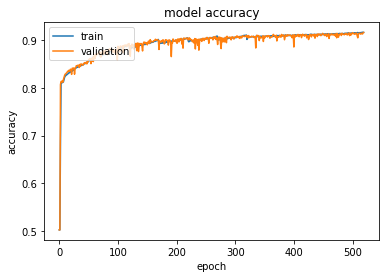

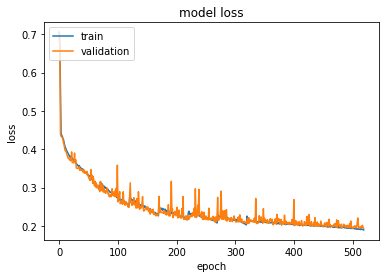

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

In [ ]:
#load model
new_model = tf.keras.models.load_model('shuffleNet_v1_0530.h5')
new_model.summary()

In [56]:
#輸出某一層模型辨識的中間值
txtfile = './shuffleNet_v1_weights/dense.txt'
layer_name = 'dense'
intermediate_layer_model = keras.Model(inputs=new_model.input,
                                       outputs=new_model.get_layer(layer_name).output)
data = nodataset[4274].reshape(1, 64, 64, 1)
intermediate_output = intermediate_layer_model.predict(data)
predict = new_model.predict(data)
with open(txtfile, 'w') as file:
    for i in range(2):
        for j in range(0):
            for k in range(0):
                file.write(f'{intermediate_output[0][j][k][i]}') #
                if k%8 < 7:
                    file.write(' ')
                else:
                    file.write('\n')
        file.write('\n')

In [ ]:
#觀察模型辨識結果及頻譜圖
layer_name = 'dense'
intermediate_layer_model = keras.Model(inputs=new_model.input,
                                       outputs=new_model.get_layer(layer_name).output)
np.set_printoptions(threshold=np.inf)
data = yesdataset[50000].reshape(1, 64, 64, 1)
print(data)
intermediate_output = intermediate_layer_model.predict(data)
predict = new_model.predict(data)
print(intermediate_output)
# x = data.reshape(64 ,64)
# #print(x.astype, x.shape)
# max = -30000
# min = 30000
# for j in range(64):
#     for k in range(64):
#         if min > x[j][k]:
#             min = x[j][k]
#         elif max < x[j][k]:
#             max = x[j][k]
# l = max - min
# for j in range(64):
#     for k in range(64):
#         x[j][k] = ((x[j][k] - min) / l)* 255
# for j in range(64):
#     for k in range(64):
#         x[j][k] = np.floor(x[j][k]).astype(int)

# fig, ax = plt.subplots(figsize = (10, 10))

# ax.set_aspect('auto')

# ax.imshow(x, interpolation='nearest')

# numrows, numcols = x.shape

# def format_coord(x, y):
#     col = int(x + 0.5)
#     row = int(y + 0.5)
#     if col >= 0 and col < numcols and row >= 0 and row < numrows:
#         z = x[row, col]
#         return 'x=%1.4f, y=%1.4f, z=%1.4f' % (x, y, z)
#     # else:
#     #     return 'x=%1.4f, y=%1.4f' % (x, y)
# ax.format_coord = format_coord
# plt.show()